In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, precision_score
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns

### Analysis of the Left Model

RILE:
neutral = 0
left = 1
right = 2

Parties:
    center = 0
    left = 1
    right = 2

In [2]:
df_test = pd.read_csv("data/model_splits/left_right_split/left_as_train/left_test_predictions.csv")
df_inference = pd.read_csv("data/model_splits/left_right_split/left_as_train/left_inference_right_predictions.csv")
df_inference_center = pd.read_csv("data/model_splits/left_right_split/left_as_train/left_inference_center_predictions.csv")
df_train = pd.read_csv("data/model_splits/left_right_split/left_as_train/train-00000-of-00001.csv")

In [3]:
df_test.shape

(12528, 9)

In [4]:
df_inference.shape

(91672, 9)

In [5]:
df_inference_center.shape

(26525, 9)

In [6]:
df_train.shape

(58067, 6)

In [7]:
df_test.head(1)

,q_sentence,q_sentence_nr,manifesto_id,main_codes,label,original_index,input_ids,attention_mask,preds
0,OUR VISION AND PLAN,1,181310_201905,0,0,196238,"[0, 14257, 468, 36296, 4248, 37330, 2, 2, 1425...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0


## Test predictions: How well does the model perform? Are the predictions significantly different than the actual codes regarding RILE?

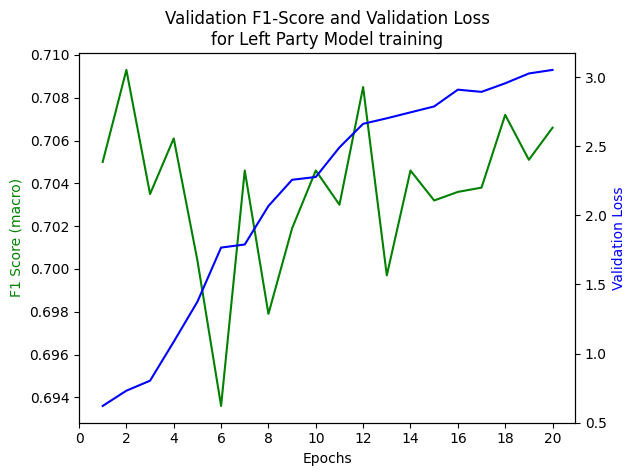

In [8]:
# model training graph:
val_f1s = [0.7050, 0.7093, 0.7035, 0.7061, 0.7004, 0.6936, 0.7046, 0.6979, 0.7019, 0.7046,
           0.7030, 0.7085, 0.6997, 0.7046, 0.7032, 0.7036, 0.7038, 0.7072, 0.7051, 0.7066]
val_loss = [0.6205, 0.7307, 0.8032, 1.0851, 1.3747, 1.7668, 1.7892, 2.0678, 2.2576, 2.2779,
            2.4922, 2.6629, 2.7028, 2.7458, 2.7886, 2.9100, 2.8942, 2.9562, 3.0273, 3.0530]
epochs = range(1,21)

fig, ax1 = plt.subplots()

# Plotting the first dataset with left y-axis
ax1.plot(epochs, val_f1s, 'g-')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('F1 Score (macro)', color='g')

# Creating a second y-axis with shared x-axis
ax2 = ax1.twinx()
ax2.plot(epochs, val_loss, 'b-')
ax2.set_ylabel('Validation Loss', color='b')

# Setting x-axis ticks every two steps
ax1.set_xticks(range(0, len(epochs)+1, 2))
ax2.set_xticks(range(0, len(epochs)+1, 2))

plt.title('Validation F1-Score and Validation Loss\nfor Left Party Model training')
plt.show()

In [9]:
print("Test set accuracy:", accuracy_score(df_test["label"], df_test["preds"]))
print("Test set precision:", precision_score(df_test["label"], df_test["preds"], average="macro"))
print("Test set recall:", recall_score(df_test["label"], df_test["preds"], average="macro"))
print("Test set F1-score:", f1_score(df_test["label"], df_test["preds"], average="macro"))

Test set accuracy: 0.7851213282247765
Test set precision: 0.7186944504350028
Test set recall: 0.7363571459713937
Test set F1-score: 0.7267660837498994


In [10]:
print("RILE distribution in training data:")
df_train["RILE"].value_counts()/df_train.shape[0]

RILE distribution in training data:


RILE
0    0.545404
1    0.322524
2    0.132072
Name: count, dtype: float64

In [11]:
print("RILE distribution in test predictions:")
df_test["preds"].value_counts()/df_test.shape[0]

RILE distribution in test predictions:


preds
0    0.555316
1    0.320003
2    0.124681
Name: count, dtype: float64

In [12]:
print("RILE distribution in real test labels:")
df_test["label"].value_counts()/df_test.shape[0]

RILE distribution in real test labels:


label
0    0.582934
1    0.303400
2    0.113665
Name: count, dtype: float64

In [13]:
#                    Pred. Neg:   Pred. Pos
#    Real Neg:       True Neg --- False Pos
#    Real Pos:       False Neg --- True Pos
print("                Pred. Neutral   Pred. Left  Pred. Right")
print("Real Neutral:")
print("Real Left:")
print("Real Right:")
print("\nAbsolut confusion matrix\n", confusion_matrix(df_test["label"], df_test["preds"]))
#print("Relativ confusion matrix\n", confusion_matrix(df_test["label"], df_test["preds"])/df_test.shape[0])

                Pred. Neutral   Pred. Left  Pred. Right
Real Neutral:
Real Left:
Real Right:

Absolut confusion matrix
 [[6030  843  430]
 [ 603 2936  262]
 [ 324  230  870]]


So, higher chance of predicting Neutral by mistake than going from left to right/right to left (makes sense!)

main_codes
706    0.165890
503    0.153774
305    0.068966
411    0.067102
705    0.046598
303    0.046598
501    0.044734
201    0.033551
410    0.031687
605    0.025163
Name: count, dtype: float64


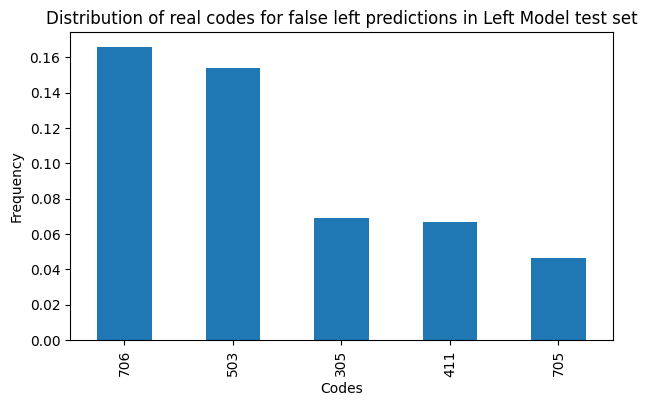

In [14]:
# Better look at the False Positives: PREDICTED LEFT but REAL RIGHT/CENTER
df_false_pos = df_test[(df_test["preds"] == 1) & (df_test["label"] != 1)]
codes_distributions = df_false_pos["main_codes"].value_counts()/df_false_pos.shape[0]
print(codes_distributions[0:10])

# Create a bar plot
plt.figure(figsize=(7, 4))
codes_distributions[0:5].plot(kind='bar')

# Add labels and title
plt.xlabel('Codes')
plt.ylabel('Frequency')
plt.title('Distribution of real codes for false left predictions in Left Model test set')

# Show the plot
plt.show()

--> 305 is a RIGHT code (Political Authority: Positive)

In [15]:
# looking at examples
pd.set_option('display.max_colwidth', 200)
target_code = 305
df_false_pos[df_false_pos["main_codes"] == target_code].tail(5)

,q_sentence,q_sentence_nr,manifesto_id,main_codes,label,original_index,input_ids,attention_mask,preds
10822,Under Rogemomics and Ruthenasia unemployment has almost trebled since 1984.,27,64321_199311,305,2,139949,"[0, 17245, 19748, 991, 26382, 8, 18825, 2457, 19036, 5755, 34, 818, 6110, 10288, 187, 11724, 4, 2, 2, 133, 6529, 40, 797, 188, 3324, 518, 98, 4886, 3168, 109, 45, 14958, 188, 3324, 268, 4, 38664, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
10831,Under the Labour Government unemployment doubled.,36,64321_199311,305,2,139958,"[0, 17245, 5, 4165, 1621, 5755, 7113, 4, 2, 2, 40, 2968, 4894, 812, 124, 20693, 188, 3324, 18, 866, 7, 1733, 92, 14275, 6, 36427, 84, 35043, 268, 6, 1304, 8, 3197, 4, 25761, 154, 1583, 9, 92, 1315...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
10832,Under National it has risen a farther 30%.,37,64321_199311,305,2,139959,"[0, 17245, 496, 24, 34, 7408, 10, 18156, 389, 2153, 2, 2, 36427, 84, 35043, 268, 6, 1304, 8, 3197, 4, 25761, 154, 1583, 9, 92, 1315, 4, 133, 1065, 924, 141, 6, 8, 596, 6, 5, 4044, 11, 1408, 476, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
10872,"And 300,000 jobless reckon there must be an alternative.",77,64321_199311,305,2,139999,"[0, 2409, 2993, 6, 151, 633, 1672, 29057, 89, 531, 28, 41, 3626, 4, 2, 2, 5488, 32, 6533, 8, 1904, 8094, 4, 713, 16, 16894, 430, 31, 5, 22, 8766, 12, 3955, 113, 1548, 9, 97, 1799, 4, 133, 6035, 20...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
10873,The Alliance is it.,78,64321_199311,305,2,140000,"[0, 133, 6035, 16, 24, 4, 2, 2, 713, 16, 16894, 430, 31, 5, 22, 8766, 12, 3955, 113, 1548, 9, 97, 1799, 4, 133, 6035, 2046, 14, 1976, 709, 1884, 8, 1435, 23, 2174, 672, 40, 342, 476, 11, 400, 1420...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1


main_codes
 504    0.115607
 503    0.066474
 202    0.063584
 706    0.062139
 403    0.060694
 410    0.056358
 705    0.054913
-1      0.044798
 607    0.043353
 411    0.043353
Name: count, dtype: float64


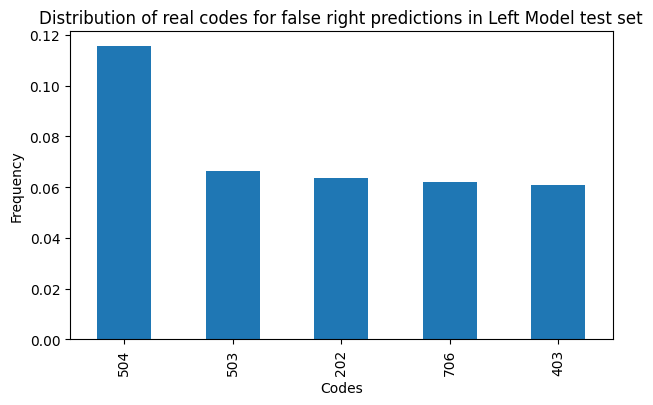

In [16]:
# Better look at the False Positives: PREDICTED RIGHT but REAL LEFT/CENTER
df_false_pos = df_test[(df_test["preds"] == 2) & (df_test["label"] != 2)]
codes_distributions = df_false_pos["main_codes"].value_counts()/df_false_pos.shape[0]
print(codes_distributions[0:10])

# Create a bar plot
plt.figure(figsize=(7, 4))
codes_distributions[0:5].plot(kind='bar')

# Add labels and title
plt.xlabel('Codes')
plt.ylabel('Frequency')
plt.title('Distribution of real codes for false right predictions in Left Model test set')

# Show the plot
plt.show()

--> 504 (Welfare State Expansion), 202 (Democracy), 403 (Market Regulation) are LEFT categories

In [17]:
# looking at examples
pd.set_option('display.max_colwidth', 200)
target_code = 202
df_false_pos[df_false_pos["main_codes"] == target_code].tail(5)

,q_sentence,q_sentence_nr,manifesto_id,main_codes,label,original_index,input_ids,attention_mask,preds
11187,"If you want 'what is in our manifesto, we ask you to support your candidate.",392,64321_199311,202,1,140314,"[0, 1106, 47, 236, 128, 12196, 16, 11, 84, 20467, 6, 52, 1394, 47, 7, 323, 110, 1984, 4, 2, 2, 5, 1582, 26335, 21, 1419, 4, 1106, 5, 6035, 56, 45, 57, 1455, 3562, 82, 74, 45, 33, 5, 9476, 122, 293...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2
11189,"When elected, I undertake during this Parliamentary term to work to implement the policies contained in the Alliance 1993 election manifesto and to remain part of the Alliance.",394,64321_199311,202,1,140316,"[0, 1779, 2736, 6, 38, 15802, 148, 42, 21879, 1385, 7, 173, 7, 5731, 5, 1986, 5558, 11, 5, 6035, 9095, 729, 20467, 8, 7, 1091, 233, 9, 5, 6035, 4, 2, 2, 113, 170, 240, 55, 6035, 6714, 11, 3879, 4,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2
11190,"Should I vote against, or obstruct the implementation of these policies, or leave the Alliance, I undertake to resign from Parliament and seek a new mandate from the electorate.",395,64321_199311,202,1,140317,"[0, 31231, 38, 900, 136, 6, 50, 17092, 5, 5574, 9, 209, 1986, 6, 50, 989, 5, 6035, 6, 38, 15802, 7, 6749, 31, 3879, 8, 2639, 10, 92, 7184, 31, 5, 17412, 4, 2, 2, 170, 240, 47, 7, 323, 110, 1984, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2
11191,I make this pledge so that electors can have full confidence that the Alliance policies they vote for will be those that will be implemented by an Alliance government.,396,64321_199311,202,1,140318,"[0, 100, 146, 42, 9461, 98, 14, 41752, 64, 33, 455, 2123, 14, 5, 6035, 1986, 51, 900, 13, 40, 28, 167, 14, 40, 28, 6264, 30, 41, 6035, 168, 4, 2, 2, 4, 12861, 6035, 1984, 16, 2021, 7, 6035, 714, 8...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2
11194,1 Honesty and accountability.,399,64321_199311,202,1,140321,"[0, 134, 8768, 27668, 8, 9563, 4, 2, 2, 1779, 2736, 6, 38, 15802, 148, 42, 21879, 1385, 7, 173, 7, 5731, 5, 1986, 5558, 11, 5, 6035, 9095, 729, 20467, 8, 7, 1091, 233, 9, 5, 6035, 4, 31231, 38, 90...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2


In [18]:
# Testing whether the predictions significantly differ from the real codes

# set up contingency table
contingency_table = pd.DataFrame({#"Group": ["# 501 codes", "# non-501 codes"],
                                  "Model": [df_test[df_test["preds"] == 0].shape[0],
                                            df_test[df_test["preds"] == 1].shape[0],
                                            df_test[df_test["preds"] == 2].shape[0]],
                                  "Coders": [df_test[df_test["label"] == 0].shape[0],
                                             df_test[df_test["label"] == 1].shape[0],
                                             df_test[df_test["label"] == 2].shape[0]]})


contingency_table

,Model,Coders
0,6957,7303
1,4009,3801
2,1562,1424


In [19]:
chi2_contingency(contingency_table)

(20.312558970744227,
 3.8831472805121255e-05,
 2,
 array([[7130., 7130.],
        [3905., 3905.],
        [1493., 1493.]]))

Model predictions on test set are significantly different to real labels (more left/right, less neutral)

### Inference Predictions (Right)

In [20]:
print("Inf set accuracy:", accuracy_score(df_inference["label"], df_inference["preds"]))
print("Inf set precision:", precision_score(df_inference["label"], df_inference["preds"], average="macro"))
print("Inf set recall:", recall_score(df_inference["label"], df_inference["preds"], average="macro"))
print("Inf set F1-score:", f1_score(df_inference["label"], df_inference["preds"], average="macro"))

Inf set accuracy: 0.7301138842830962
Inf set precision: 0.7101466659298644
Inf set recall: 0.7272485473192276
Inf set F1-score: 0.7155758754914531


In [21]:
print("RILE distribution in training data:")
df_train["RILE"].value_counts()/df_train.shape[0]

RILE distribution in training data:


RILE
0    0.545404
1    0.322524
2    0.132072
Name: count, dtype: float64

In [22]:
print("RILE distribution in inference (Right) predictions:")
df_inference["preds"].value_counts()/df_inference.shape[0]

RILE distribution in inference (Right) predictions:


preds
0    0.443418
1    0.282060
2    0.274522
Name: count, dtype: float64

In [23]:
print("RILE distribution in inference (Right) real labels:")
df_inference["label"].value_counts()/df_inference.shape[0]

RILE distribution in inference (Right) real labels:


label
0    0.494655
2    0.275035
1    0.230310
Name: count, dtype: float64

Occurence of right stable, but more left and less neutral

In [24]:
#                    Pred. Neg:   Pred. Pos
#    Real Neg:       True Neg --- False Pos
#    Real Pos:       False Neg --- True Pos
print("                Pred. Neutral   Pred. Left  Pred. Right")
print("Real Neutral:")
print("Real Left:")
print("Real Right:")
print("\nAbsolut confusion matrix\n", confusion_matrix(df_inference["label"], df_inference["preds"]))
#print("Relativ confusion matrix\n", confusion_matrix(df_test["label"], df_test["preds"])/df_test.shape[0])

                Pred. Neutral   Pred. Left  Pred. Right
Real Neutral:
Real Left:
Real Right:

Absolut confusion matrix
 [[33840  5990  5516]
 [ 2608 15973  2532]
 [ 4201  3894 17118]]


main_codes
503    0.125152
411    0.078005
505    0.067685
401    0.062930
303    0.054027
706    0.051801
605    0.044314
305    0.039964
402    0.037232
201    0.034096
Name: count, dtype: float64


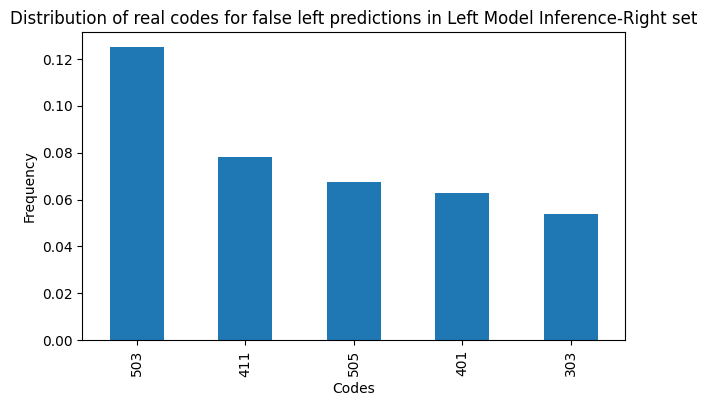

In [25]:
# Better look at the False Positives: PREDICTED LEFT but REAL RIGHT/CENTER
df_false_pos = df_inference[(df_inference["preds"] == 1) & (df_inference["label"] != 1)]
codes_distributions = df_false_pos["main_codes"].value_counts()/df_false_pos.shape[0]
print(codes_distributions[0:10])

# Create a bar plot
plt.figure(figsize=(7, 4))
codes_distributions[0:5].plot(kind='bar')

# Add labels and title
plt.xlabel('Codes')
plt.ylabel('Frequency')
plt.title('Distribution of real codes for false left predictions in Left Model Inference-Right set')

# Show the plot
plt.show()

In [26]:
# looking at examples
pd.set_option('display.max_colwidth', 200)
target_code = 505
df_false_pos[df_false_pos["main_codes"] == target_code].tail(5)

,q_sentence,q_sentence_nr,manifesto_id,main_codes,label,original_index,input_ids,attention_mask,preds
91011,New Zealand has far too many DHBs.,521,64621_202010,505,2,185271,"[0, 4030, 3324, 34, 444, 350, 171, 21391, 28720, 4, 2, 2, 4030, 3324, 1234, 2046, 11, 6060, 1318, 3717, 13, 70, 188, 3324, 268, 4, 1711, 16, 596, 52, 32, 15670, 10, 10606, 9, 1986, 14, 244, 17996,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
91020,New Zealand needs no more than 7 DHBs,530,64621_202010,505,2,185280,"[0, 4030, 3324, 782, 117, 55, 87, 262, 21391, 28720, 2, 2, 961, 3620, 107, 9, 1046, 8, 2530, 8, 172, 7, 961, 1493, 4, 713, 714, 34, 7, 28, 142, 9, 63, 701, 6, 839, 12, 33882, 36, 627, 746, 701, 16...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
91193,Implement the changes made by the “Fair Residency Bill” which will increase the age of eligibility for New Zealand Superannuation from 10 to 20 years,703,64621_202010,505,2,185453,"[0, 20470, 40224, 5, 1022, 156, 30, 5, 44, 48, 33648, 4787, 41059, 1585, 17, 46, 61, 40, 712, 5, 1046, 9, 14199, 13, 188, 3324, 1582, 2279, 9762, 31, 158, 7, 291, 107, 2, 2, 19923, 24343, 5, 6397,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
91229,reducing their time on the benefit,739,64621_202010,505,2,185489,"[0, 2050, 30623, 49, 86, 15, 5, 1796, 2, 2, 47279, 5, 692, 9, 2573, 8, 19410, 1293, 98, 14, 5, 1387, 9, 2573, 8, 19410, 15816, 64, 3003, 15194, 1822, 1328, 188, 3324, 15833, 7, 5731, 5, 4664, 9, 5...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
91419,"It is necessary to abolish privileged pensions, with the exception for those who suffered for Poland's independence and reconstruction.",68,92710_199110,505,2,186841,"[0, 243, 16, 2139, 7, 31165, 18560, 15131, 6, 19, 5, 8219, 13, 167, 54, 2152, 13, 6508, 18, 5201, 8, 18228, 4, 2, 2, 4629, 13216, 4629, 12613, 4248, 15421, 250, 31071, 221, 12743, 11654, 6, 29000,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1


main_codes
 410    0.149230
 403    0.089463
 411    0.077038
 303    0.060636
 504    0.053429
 703    0.047589
 503    0.047217
 706    0.047092
-1      0.043116
 202    0.039140
Name: count, dtype: float64


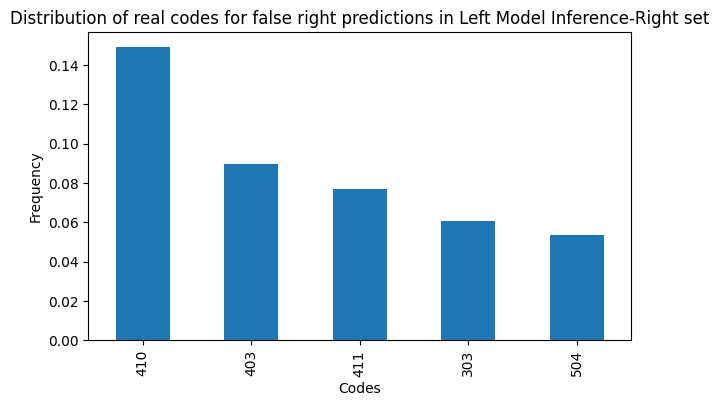

In [27]:
# Better look at the False Positives: PREDICTED RIGHT but REAL LEFT/CENTER
df_false_pos = df_inference[(df_inference["preds"] == 2) & (df_inference["label"] != 2)]
codes_distributions = df_false_pos["main_codes"].value_counts()/df_false_pos.shape[0]
print(codes_distributions[0:10])

# Create a bar plot
plt.figure(figsize=(7, 4))
codes_distributions[0:5].plot(kind='bar')

# Add labels and title
plt.xlabel('Codes')
plt.ylabel('Frequency')
plt.title('Distribution of real codes for false right predictions in Left Model Inference-Right set')

# Show the plot
plt.show()

Except for 403, rather big changes here... (maybe make graph showing risers/fallers in false positive distributions between test and inference sets?)

In [28]:
# looking at examples
pd.set_option('display.max_colwidth', 200)
target_code = 504
df_false_pos[df_false_pos["main_codes"] == target_code].tail(5)

,q_sentence,q_sentence_nr,manifesto_id,main_codes,label,original_index,input_ids,attention_mask,preds
91218,thereby also freeing up administration costs to reinvest in families,728,64621_202010,504,1,185478,"[0, 8585, 1409, 67, 30130, 62, 942, 1042, 7, 24090, 11, 1232, 2, 2, 30, 4848, 11, 8555, 8, 419, 6530, 111, 44, 48, 9289, 253, 5, 1930, 17, 46, 14, 52, 40, 28, 441, 7, 386, 7, 1004, 159, 103, 9, 5,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2
91223,Fund pilot programmes such as Hokonui Huanui in Gore and the Wairoa Community Partnership Group to create resilient communities by providing prevention and early intervention services,733,64621_202010,504,1,185483,"[0, 13632, 4792, 8864, 215, 25, 26455, 261, 3371, 289, 7372, 3371, 11, 16603, 8, 5, 305, 14387, 102, 2573, 11697, 826, 7, 1045, 15194, 1822, 30, 1976, 8555, 8, 419, 6530, 518, 2, 2, 1042, 7, 24090...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2
91272,"We believe that policy must reflect this as our nation has a special obligation to our veterans, especially those who have suffered as a result of their service.",782,64621_202010,504,1,185532,"[0, 170, 679, 14, 714, 531, 4227, 42, 25, 84, 1226, 34, 10, 780, 9061, 7, 84, 4823, 6, 941, 167, 54, 33, 2152, 25, 10, 898, 9, 49, 544, 4, 2, 2, 36590, 8, 1498, 5, 6507, 3898, 15220, 14135, 369, 3...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2
91279,Respond to the recommendations of the Veterans’ Advisory Board that the definition of a veteran be expanded so that all who have served are considered veterans,789,64621_202010,504,1,185539,"[0, 44036, 2832, 7, 5, 4664, 9, 5, 8815, 17, 27, 11067, 1785, 14, 5, 8515, 9, 10, 3142, 28, 4939, 98, 14, 70, 54, 33, 1665, 32, 1687, 4823, 2, 2, 1234, 2127, 372, 923, 8, 4972, 15, 5, 544, 8, 9802...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2
91308,good credits for house buyers,29,92410_199309,504,1,187127,"[0, 8396, 7751, 13, 790, 4859, 2, 2, 21536, 2492, 8662, 13083, 40, 304, 70, 5, 839, 7, 5217, 1846, 24769, 2590, 13040, 5, 249, 1572, 37362, 5, 8882, 566, 5, 249, 1572, 37343, 1755, 92, 2074, 11, 6...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2


In [29]:
# Testing whether the predictions significantly differ from the real codes

# set up contingency table
contingency_table = pd.DataFrame({#"Group": ["# 501 codes", "# non-501 codes"],
                                  "Model": [df_inference[df_inference["preds"] == 0].shape[0],
                                            df_inference[df_inference["preds"] == 1].shape[0],
                                            df_inference[df_inference["preds"] == 2].shape[0]],
                                  "Coders": [df_inference[df_inference["label"] == 0].shape[0],
                                             df_inference[df_inference["label"] == 1].shape[0],
                                             df_inference[df_inference["label"] == 2].shape[0]]})


contingency_table

,Model,Coders
0,40649,45346
1,25857,21113
2,25166,25213


Very close in number of right predictions! But large differences between left and neutral (Maybe count the concrete number going from which to what and compare these between test/inf sets)

In [30]:
chi2_contingency(contingency_table)

(735.7384560016667,
 1.7235513114945206e-160,
 2,
 array([[42997.5, 42997.5],
        [23485. , 23485. ],
        [25189.5, 25189.5]]))

So the model predictions are very clearly significantly different that the real predictions!

### Inference Predictions (Center)

In [32]:
print("Inf set accuracy:", accuracy_score(df_inference_center["label"], df_inference_center["preds"]))
print("Inf set precision:", precision_score(df_inference_center["label"], df_inference_center["preds"], average="macro"))
print("Inf set recall:", recall_score(df_inference_center["label"], df_inference_center["preds"], average="macro"))
print("Inf set F1-score:", f1_score(df_inference_center["label"], df_inference_center["preds"], average="macro"))

Inf set accuracy: 0.7615834118755891
Inf set precision: 0.7243623149899284
Inf set recall: 0.7439147932531593
Inf set F1-score: 0.7323212475209155


In [33]:
print("RILE distribution in training data:")
df_train["RILE"].value_counts()/df_train.shape[0]

RILE distribution in training data:


RILE
0    0.545404
1    0.322524
2    0.132072
Name: count, dtype: float64

In [34]:
print("RILE distribution in inference (Center) predictions:")
df_inference_center["preds"].value_counts()/df_inference_center.shape[0]

RILE distribution in inference (Center) predictions:


preds
0    0.502507
1    0.313063
2    0.184430
Name: count, dtype: float64

In [35]:
print("RILE distribution in inference (Center) real labels:")
df_inference_center["label"].value_counts()/df_inference_center.shape[0]

RILE distribution in inference (Center) real labels:


label
0    0.551593
1    0.275137
2    0.173270
Name: count, dtype: float64

More left predictions, less neutral predictions

In [36]:
#                    Pred. Neg:   Pred. Pos
#    Real Neg:       True Neg --- False Pos
#    Real Pos:       False Neg --- True Pos
print("                Pred. Neutral   Pred. Left  Pred. Right")
print("Real Neutral:")
print("Real Left:")
print("Real Right:")
print("\nAbsolut confusion matrix\n", confusion_matrix(df_inference_center["label"], df_inference_center["preds"]))
#print("Relativ confusion matrix\n", confusion_matrix(df_test["label"], df_test["preds"])/df_test.shape[0])


                Pred. Neutral   Pred. Left  Pred. Right
Real Neutral:
Real Left:
Real Right:

Absolut confusion matrix
 [[11431  1970  1230]
 [ 1042  5682   574]
 [  856   652  3088]]


main_codes
503    0.136156
303    0.102975
706    0.092296
411    0.073608
301    0.050725
0      0.044622
305    0.040046
705    0.035469
204    0.032418
603    0.031655
Name: count, dtype: float64


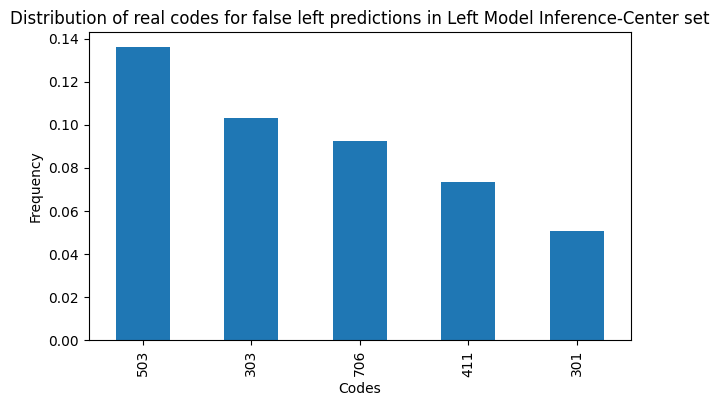

In [37]:
# Better look at the False Positives: PREDICTED LEFT but REAL RIGHT/CENTER
df_false_pos = df_inference_center[(df_inference_center["preds"] == 1) & (df_inference_center["label"] != 1)]
codes_distributions = df_false_pos["main_codes"].value_counts()/df_false_pos.shape[0]
print(codes_distributions[0:10])

# Create a bar plot
plt.figure(figsize=(7, 4))
codes_distributions[0:5].plot(kind='bar')

# Add labels and title
plt.xlabel('Codes')
plt.ylabel('Frequency')
plt.title('Distribution of real codes for false left predictions in Left Model Inference-Center set')

# Show the plot
plt.show()


In [38]:
# looking at examples
pd.set_option('display.max_colwidth', 200)
target_code = 505
df_false_pos[df_false_pos["main_codes"] == target_code].tail(5)


,q_sentence,q_sentence_nr,manifesto_id,main_codes,label,original_index,input_ids,attention_mask,preds
25699, Review Housing NZ tenancies on an annual basis to ensure that the occupants still meet the criteria,843,64421_201409,505,2,162943,"[0, 43251, 9264, 18400, 1437, 5872, 8160, 15930, 2724, 27661, 15, 41, 1013, 1453, 7, 1306, 14, 5, 19062, 202, 972, 5, 8608, 2, 2, 68, 134, 153, 238, 50, 167, 3611, 14, 32, 45, 36614, 13, 167, 54, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
25724,"In UnitedFuture’s view, the provisions of Section 70 should only apply where the overseas pension in question has been fully funded from general tax revenues.",868,64421_201409,505,2,162968,"[0, 1121, 315, 37577, 17, 27, 29, 1217, 6, 5, 7668, 9, 7162, 1510, 197, 129, 3253, 147, 5, 4886, 4931, 11, 864, 34, 57, 1950, 6140, 31, 937, 629, 3883, 4, 2, 2, 14, 35, 43251, 9264, 18400, 1437, 3...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
25726,This would mean that the only pension arrangements to be captured by the provision of Section 70 would be national tax-payer funded pension schemes in other countries.,870,64421_201409,505,2,162970,"[0, 713, 74, 1266, 14, 5, 129, 4931, 7863, 7, 28, 4705, 30, 5, 6397, 9, 7162, 1510, 74, 28, 632, 629, 12, 30446, 6140, 4931, 10419, 11, 97, 749, 4, 2, 2, 61, 188, 3324, 1795, 8, 15131, 74, 28, 119...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
25744," Ensure that sickness and invalids beneficiaries seek treatment for their incapacity where this is appropriate as a condition of their benefit,",888,64421_201409,505,2,162988,"[0, 43251, 9264, 18400, 1437, 38141, 14, 25231, 8, 48544, 7823, 14956, 2639, 1416, 13, 49, 45607, 18583, 147, 42, 16, 3901, 25, 10, 1881, 9, 49, 1796, 6, 2, 2, 11694, 39922, 359, 14850, 7205, 2066...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
25746, Closely monitor the effectiveness of current initiatives for moving domestic purposes recipients into appropriate employment as their children get older;,890,64421_201409,505,2,162990,"[0, 43251, 9264, 18400, 1437, 10041, 352, 5271, 5, 12833, 9, 595, 5287, 13, 1375, 1897, 6216, 11940, 88, 3901, 4042, 25, 49, 408, 120, 2530, 131, 2, 2, 10, 1472, 9, 1081, 12028, 6, 8, 1639, 10, 77...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1


main_codes
 504    0.109756
 410    0.090909
 403    0.078714
-1      0.074834
 411    0.069290
 408    0.067627
 0      0.061530
 303    0.054878
 503    0.050998
 706    0.041020
Name: count, dtype: float64


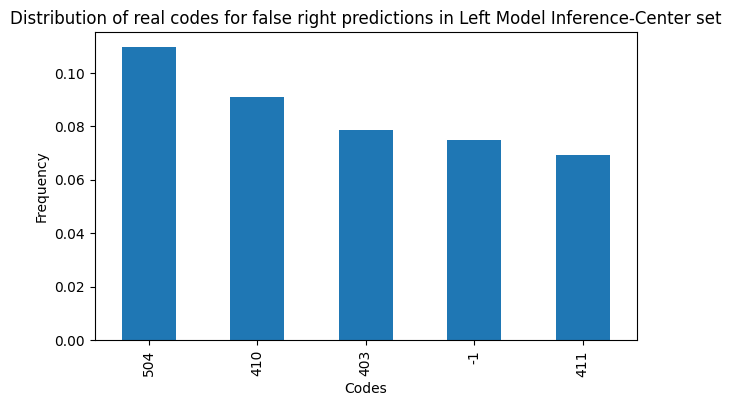

In [39]:
# Better look at the False Positives: PREDICTED RIGHT but REAL LEFT/CENTER
df_false_pos = df_inference_center[(df_inference_center["preds"] == 2) & (df_inference_center["label"] != 2)]
codes_distributions = df_false_pos["main_codes"].value_counts()/df_false_pos.shape[0]
print(codes_distributions[0:10])

# Create a bar plot
plt.figure(figsize=(7, 4))
codes_distributions[0:5].plot(kind='bar')

# Add labels and title
plt.xlabel('Codes')
plt.ylabel('Frequency')
plt.title('Distribution of real codes for false right predictions in Left Model Inference-Center set')

# Show the plot
plt.show()


In [40]:
# looking at examples
pd.set_option('display.max_colwidth', 200)
target_code = 504
df_false_pos[df_false_pos["main_codes"] == target_code].tail(5)


,q_sentence,q_sentence_nr,manifesto_id,main_codes,label,original_index,input_ids,attention_mask,preds
26028,It is UnitedFuture policy to: Make drug and alcohol rehabilitation courses available for inmates who have been identified with drug or alcohol addictions;,1172,64421_201409,504,1,163272,"[0, 243, 16, 315, 37577, 714, 7, 35, 43251, 9264, 18400, 1437, 5293, 1262, 8, 3766, 11226, 7484, 577, 13, 8039, 54, 33, 57, 2006, 19, 1262, 50, 3766, 1606, 19047, 131, 2, 2, 15638, 30623, 7382, 80...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2
26323,"support for voluntary organisations,",240,64951_198407,504,1,137346,"[0, 22930, 13, 11659, 7260, 6, 2, 2, 170, 40, 712, 5, 443, 9, 1212, 223, 6693, 30, 1976, 629, 12889, 13, 3380, 29767, 6, 39149, 10686, 1212, 31, 940, 2203, 6, 463, 5513, 1029, 12, 23655, 16186, 4,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2
26334,"A Sociological Research Centre will investigate serious problems e.g. crime and violence, illegitimacy, alcoholism",251,64951_198407,504,1,137357,"[0, 250, 35160, 9779, 1624, 2521, 40, 4830, 1473, 1272, 364, 4, 571, 4, 1437, 1846, 8, 1476, 6, 32563, 405, 757, 5073, 6, 37934, 2, 2, 102, 55, 38853, 6784, 7, 2536, 474, 6, 28746, 12, 12528, 2159...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2
26382,"providing additional welfare officers in courts and prisons,",299,64951_198407,504,1,137405,"[0, 13138, 8231, 943, 6642, 1024, 11, 4354, 8, 14867, 6, 2, 2, 574, 10751, 4979, 38036, 250, 1585, 9, 3941, 40, 28, 2942, 7, 3000, 5, 476, 9, 168, 8, 18552, 5, 1736, 136, 5, 11307, 9, 659, 8, 2620...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2
26476,and improve support for voluntary agencies.,393,64951_198407,504,1,137499,"[0, 463, 1477, 323, 13, 11659, 2244, 4, 2, 2, 1290, 2407, 41, 9077, 3041, 9, 5058, 9, 2139, 6087, 3183, 6, 34335, 2388, 1029, 12, 20829, 227, 1138, 8, 1052, 6, 30248, 7189, 1048, 13, 4302, 6, 463,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2


In [41]:
# Testing whether the predictions significantly differ from the real codes

# set up contingency table
contingency_table = pd.DataFrame({#"Group": ["# 501 codes", "# non-501 codes"],
                                  "Model": [df_inference_center[df_inference_center["preds"] == 0].shape[0],
                                            df_inference_center[df_inference_center["preds"] == 1].shape[0],
                                            df_inference_center[df_inference_center["preds"] == 2].shape[0]],
                                  "Coders": [df_inference_center[df_inference_center["label"] == 0].shape[0],
                                             df_inference_center[df_inference_center["label"] == 1].shape[0],
                                             df_inference_center[df_inference_center["label"] == 2].shape[0]]})


contingency_table


,Model,Coders
0,13329,14631
1,8304,7298
2,4892,4596


Quite close in number of right predictions! But large differences between left and neutral (Maybe count the concrete number going from which to what and compare these between test/inf sets)


In [42]:
chi2_contingency(contingency_table)

(134.7298015206143,
 5.5436439071584456e-30,
 2,
 array([[13980., 13980.],
        [ 7801.,  7801.],
        [ 4744.,  4744.]]))

Unterschiede in den False-Positive Distributions von Test zu Center zu Right (Inference)

False left predictions:

In [43]:
all_codes = set(df_train["main_codes"].unique())

# test:
tmp = df_test[(df_test["preds"] == 1) & (df_test["label"] != 1)]
false_left_test = tmp["main_codes"].value_counts()/tmp.shape[0]
# add missing codes:
false_left_test = pd.concat([false_left_test, pd.Series(0, index=all_codes-set(false_left_test.index))]).sort_index()

# inference center
tmp = df_inference_center[(df_inference_center["preds"] == 1) & (df_inference_center["label"] != 1)]
false_left_center = tmp["main_codes"].value_counts()/tmp.shape[0]
false_left_center = pd.concat([false_left_center, pd.Series(0, index=all_codes-set(false_left_center.index))]).sort_index()

# inference right
tmp = df_inference[(df_inference["preds"] == 1) & (df_inference["label"] != 1)]
false_left_right = tmp["main_codes"].value_counts()/tmp.shape[0]
false_left_right = pd.concat([false_left_right, pd.Series(0, index=all_codes-set(false_left_right.index))]).sort_index()

In [ ]:
# sort by the main codes and calculate the difference (so going from test to center and test to right)

In [44]:
test_to_center = (false_left_center - false_left_test).sort_values(ascending=False)
test_to_right = (false_left_right - false_left_test).sort_values(ascending=False)

In [45]:
test_to_center

 303    0.056377
 0      0.035303
 301    0.026494
 505    0.022969
 104    0.018562
 414    0.017756
 603    0.017676
 704    0.017036
 402    0.015981
 204    0.014711
 408    0.013394
 411    0.006506
 401    0.006400
 703    0.004918
-1      0.004881
 405    0.003478
 502    0.003054
 102    0.001738
 604    0.001356
 110    0.001144
 302    0.000680
 608    0.000381
 105    0.000000
 413    0.000000
 412    0.000000
 106    0.000000
 103    0.000000
 202    0.000000
 107    0.000000
 406    0.000000
 404    0.000000
 403    0.000000
 504    0.000000
 701    0.000000
 506    0.000000
 415    0.000000
 203   -0.000169
 602   -0.000465
 507   -0.000889
 605   -0.001517
 601   -0.002156
 702   -0.002202
 108   -0.002412
 109   -0.004235
 409   -0.004448
 407   -0.008132
 606   -0.010037
 416   -0.010123
 304   -0.011098
 705   -0.011129
 101   -0.013045
 201   -0.014100
 503   -0.017619
 607   -0.019061
 410   -0.022152
 305   -0.028920
 501   -0.033293
 706   -0.073594
dtype: float64

In [85]:
test_to_right

 505    0.063957
 401    0.058270
 104    0.029478
 702    0.026118
 402    0.022320
 703    0.019680
 605    0.019151
 507    0.013594
 601    0.011719
 109    0.011586
-1      0.011244
 411    0.010903
 101    0.009018
 303    0.007428
 603    0.007267
 414    0.005138
 110    0.003845
 102    0.002913
 704    0.002364
 203    0.002204
 0      0.001202
 604    0.000889
 608    0.000607
 201    0.000545
 415    0.000101
 504    0.000000
 103    0.000000
 105    0.000000
 202    0.000000
 413    0.000000
 412    0.000000
 701    0.000000
 107    0.000000
 404    0.000000
 403    0.000000
 506    0.000000
 106    0.000000
 406    0.000000
 407   -0.000459
 408   -0.000640
 502   -0.002418
 602   -0.002738
 409   -0.002759
 302   -0.003547
 410   -0.005179
 301   -0.005615
 405   -0.006812
 607   -0.007964
 304   -0.008639
 606   -0.010972
 108   -0.010981
 416   -0.012909
 204   -0.015482
 503   -0.028623
 305   -0.029002
 705   -0.031523
 501   -0.041193
 706   -0.114089
dtype: float64

In [47]:
interesting_codes = [505, 401, 501, 706]
d_test_selection = false_left_test.loc[interesting_codes]
d_inf_center_selection = false_left_center.loc[interesting_codes]
d_inf_right_selection = false_left_right.loc[interesting_codes]
df_tmp = pd.DataFrame({"Test set (Left manifestos)": d_test_selection*100,
                       "Inference set (Center manifestos)": d_inf_center_selection*100,
                       "Inference set (Right manifestos)": d_inf_right_selection*100})
df_tmp

,Test set (Left manifestos),Inference set (Center manifestos),Inference set (Right manifestos)
505,0.372787,2.669718,6.768515
401,0.465983,1.106026,6.292999
501,4.473439,1.144165,0.354108
706,16.589003,9.229596,5.180089


C:\Users\Konstantin\AppData\Local\Temp\ipykernel_3604\3284473593.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(percent_ticks)


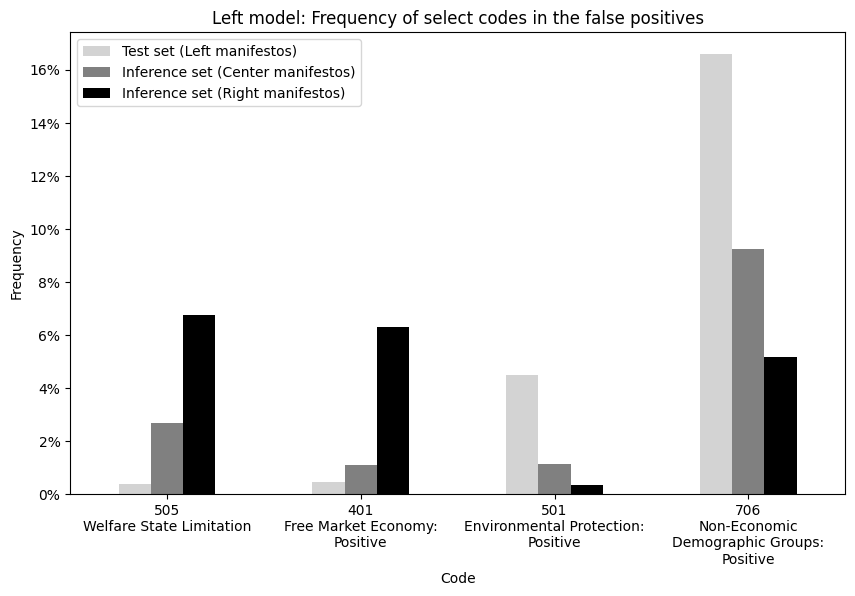

In [53]:
# Plotting
ax = df_tmp.plot(kind='bar', color=['lightgrey', 'grey', 'black'], figsize=(10, 6))

# Customizing labels and title
ax.set_xlabel('Code')
ax.set_ylabel('Frequency')
ax.set_title('Left model: Frequency of select codes in the false positives')

# add % to y axis ticks
ticks = ax.get_yticks()
percent_ticks = [f'{int(t)}%' for t in ticks]
ax.set_yticklabels(percent_ticks)

new_labels = ['505\nWelfare State Limitation', '401\nFree Market Economy:\nPositive',
              '501\nEnvironmental Protection:\nPositive', '706\nNon-Economic\nDemographic Groups:\nPositive']
ax.set_xticklabels(new_labels, rotation=0)

plt.show()